# Temporal Clustering Analysis of Auction Bids
## Exploring bid clustering patterns by hours_since_first_bid

This notebook analyzes how bids cluster temporally using the `hours_since_first_bid` feature from the engineered bid history data. We'll explore:
- Distribution of bid timing
- Clustering algorithms (K-Means, DBSCAN, Hierarchical)
- Cluster characteristics and patterns
- Insights about bidding behavior over time

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("TEMPORAL CLUSTERING ANALYSIS - BID TIMING PATTERNS")
print("="*80)
print("\nLibraries loaded successfully!")

TEMPORAL CLUSTERING ANALYSIS - BID TIMING PATTERNS

Libraries loaded successfully!


In [2]:
# Load data
print("Loading bid history data...")
data_path = "/workspaces/maxsold/data/engineered_data/bid_history/bid_history_engineered_20251201.parquet"
df = pd.read_parquet(data_path)

print(f"\nData loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Focus on hours_since_first_bid for temporal clustering
print(f"\nhours_since_first_bid statistics:")
print(df['hours_since_first_bid'].describe())

print(f"\nData range:")
print(f"  Min: {df['hours_since_first_bid'].min():.2f} hours")
print(f"  Max: {df['hours_since_first_bid'].max():.2f} hours")
print(f"  Mean: {df['hours_since_first_bid'].mean():.2f} hours")
print(f"  Median: {df['hours_since_first_bid'].median():.2f} hours")

df.head()

Loading bid history data...

Data loaded successfully!
Shape: 2,107,247 rows × 15 columns

hours_since_first_bid statistics:
count    2.107247e+06
mean     9.955186e+01
std      7.628525e+01
min      0.000000e+00
25%      2.781444e+01
50%      9.516083e+01
75%      1.565925e+02
max      3.358661e+02
Name: hours_since_first_bid, dtype: float64

Data range:
  Min: 0.00 hours
  Max: 335.87 hours
  Mean: 99.55 hours
  Median: 95.16 hours


,auction_id,item_id,bid_number,time_of_bid,amount,isproxy,total_bids_for_item,first_bid_time,last_bid_time,hours_since_first_bid,proxy_bid_count,manual_bid_count,proxy_bid_ratio,bid_increment,bid_position_pct
0,36194,3430422,1,2021-10-16 03:28:16-05:00,1.0,False,7,2021-10-16 03:28:16-05:00,2021-10-16 21:49:41-05:00,0.000000,2,5,0.285714,0.0,0.142857
1,36194,3430422,2,2021-10-16 08:55:07-05:00,2.0,False,7,2021-10-16 03:28:16-05:00,2021-10-16 21:49:41-05:00,5.447500,2,5,0.285714,1.0,0.285714
2,36194,3430422,3,2021-10-16 09:25:09-05:00,3.0,False,7,2021-10-16 03:28:16-05:00,2021-10-16 21:49:41-05:00,5.948056,2,5,0.285714,1.0,0.428571
3,36194,3430422,4,2021-10-16 21:49:23-05:00,5.0,False,7,2021-10-16 03:28:16-05:00,2021-10-16 21:49:41-05:00,18.351944,2,5,0.285714,2.0,0.571429
4,36194,3430422,5,2021-10-16 21:49:23-05:00,6.0,True,7,2021-10-16 03:28:16-05:00,2021-10-16 21:49:41-05:00,18.351944,2,5,0.285714,1.0,0.714286


DISTRIBUTION ANALYSIS


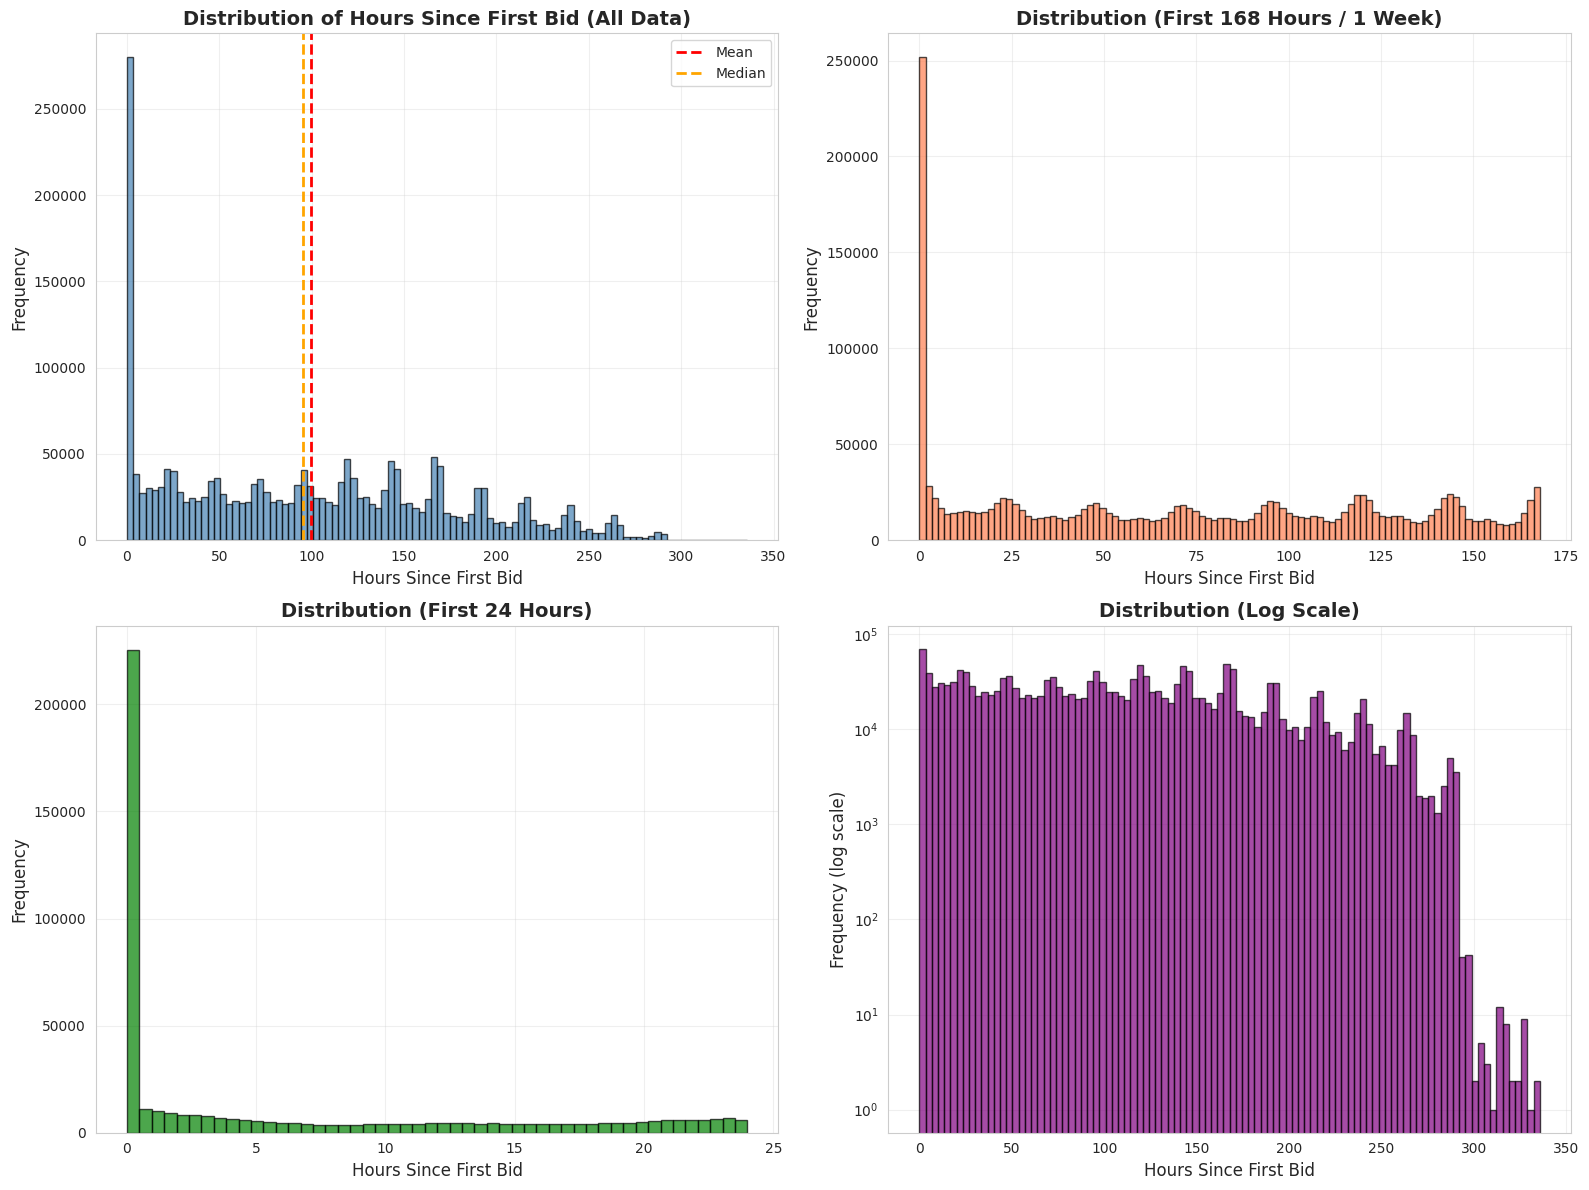


Bid distribution by time periods:
  0-1 hour: 237,314 bids (11.3%)
  1-6 hours: 74,564 bids
  6-24 hours: 171,699 bids
  1-3 days: 389,995 bids
  3-7 days: 802,765 bids
  7+ days: 430,910 bids


In [3]:
# Exploratory Analysis of hours_since_first_bid Distribution
print("="*80)
print("DISTRIBUTION ANALYSIS")
print("="*80)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram - all data
axes[0, 0].hist(df['hours_since_first_bid'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Hours Since First Bid (All Data)', fontsize=14, fontweight='bold')
axes[0, 0].axvline(df['hours_since_first_bid'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(df['hours_since_first_bid'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram - first 168 hours (1 week)
week_data = df[df['hours_since_first_bid'] <= 168]
axes[0, 1].hist(week_data['hours_since_first_bid'], bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Distribution (First 168 Hours / 1 Week)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram - first 24 hours
day_data = df[df['hours_since_first_bid'] <= 24]
axes[1, 0].hist(day_data['hours_since_first_bid'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Distribution (First 24 Hours)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Log scale
axes[1, 1].hist(df[df['hours_since_first_bid'] > 0]['hours_since_first_bid'], bins=100, 
                edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Hours Since First Bid', fontsize=12)
axes[1, 1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1, 1].set_title('Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time buckets analysis
print("\nBid distribution by time periods:")
print(f"  0-1 hour: {(df['hours_since_first_bid'] <= 1).sum():,} bids ({100*(df['hours_since_first_bid'] <= 1).sum()/len(df):.1f}%)")
print(f"  1-6 hours: {((df['hours_since_first_bid'] > 1) & (df['hours_since_first_bid'] <= 6)).sum():,} bids")
print(f"  6-24 hours: {((df['hours_since_first_bid'] > 6) & (df['hours_since_first_bid'] <= 24)).sum():,} bids")
print(f"  1-3 days: {((df['hours_since_first_bid'] > 24) & (df['hours_since_first_bid'] <= 72)).sum():,} bids")
print(f"  3-7 days: {((df['hours_since_first_bid'] > 72) & (df['hours_since_first_bid'] <= 168)).sum():,} bids")
print(f"  7+ days: {(df['hours_since_first_bid'] > 168).sum():,} bids")

In [4]:
# Prepare data for clustering
print("="*80)
print("PREPARING DATA FOR CLUSTERING")
print("="*80)

# Use a sample for faster processing (adjust if needed)
sample_size = min(100000, len(df))
df_sample = df.sample(n=sample_size, random_state=42).copy()

print(f"\nUsing sample of {len(df_sample):,} bids for clustering analysis")

# Prepare feature matrix for clustering (univariate clustering on hours_since_first_bid)
X = df_sample[['hours_since_first_bid']].values

# Also prepare scaled version
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Feature: hours_since_first_bid")
print(f"\nScaled data statistics:")
print(f"  Mean: {X_scaled.mean():.4f}")
print(f"  Std: {X_scaled.std():.4f}")

# Remove outliers for better clustering (optional - using IQR method)
Q1 = df_sample['hours_since_first_bid'].quantile(0.25)
Q3 = df_sample['hours_since_first_bid'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_sample[(df_sample['hours_since_first_bid'] >= lower_bound) & 
                            (df_sample['hours_since_first_bid'] <= upper_bound)].copy()

print(f"\nOutlier removal (IQR method):")
print(f"  Original sample: {len(df_sample):,} bids")
print(f"  After removing outliers: {len(df_no_outliers):,} bids")
print(f"  Outliers removed: {len(df_sample) - len(df_no_outliers):,} ({100*(len(df_sample)-len(df_no_outliers))/len(df_sample):.1f}%)")
print(f"  Lower bound: {lower_bound:.2f} hours")
print(f"  Upper bound: {upper_bound:.2f} hours")

PREPARING DATA FOR CLUSTERING

Using sample of 100,000 bids for clustering analysis

Feature matrix shape: (100000, 1)
Feature: hours_since_first_bid

Scaled data statistics:
  Mean: -0.0000
  Std: 1.0000

Outlier removal (IQR method):
  Original sample: 100,000 bids
  After removing outliers: 100,000 bids
  Outliers removed: 0 (0.0%)
  Lower bound: -165.34 hours
  Upper bound: 349.96 hours


K-MEANS CLUSTERING - ELBOW METHOD

Testing K-Means with different numbers of clusters...
  k=2: Inertia=27260.36, Silhouette=0.619, Davies-Bouldin=0.520
  k=3: Inertia=12194.98, Silhouette=0.598, Davies-Bouldin=0.525
  k=4: Inertia=6801.93, Silhouette=0.589, Davies-Bouldin=0.504
  k=5: Inertia=4238.03, Silhouette=0.590, Davies-Bouldin=0.492
  k=6: Inertia=2968.63, Silhouette=0.593, Davies-Bouldin=0.501
  k=7: Inertia=2162.00, Silhouette=0.579, Davies-Bouldin=0.497
  k=8: Inertia=1672.70, Silhouette=0.578, Davies-Bouldin=0.500
  k=9: Inertia=1333.11, Silhouette=0.576, Davies-Bouldin=0.493
  k=10: Inertia=1018.27, Silhouette=0.600, Davies-Bouldin=0.467


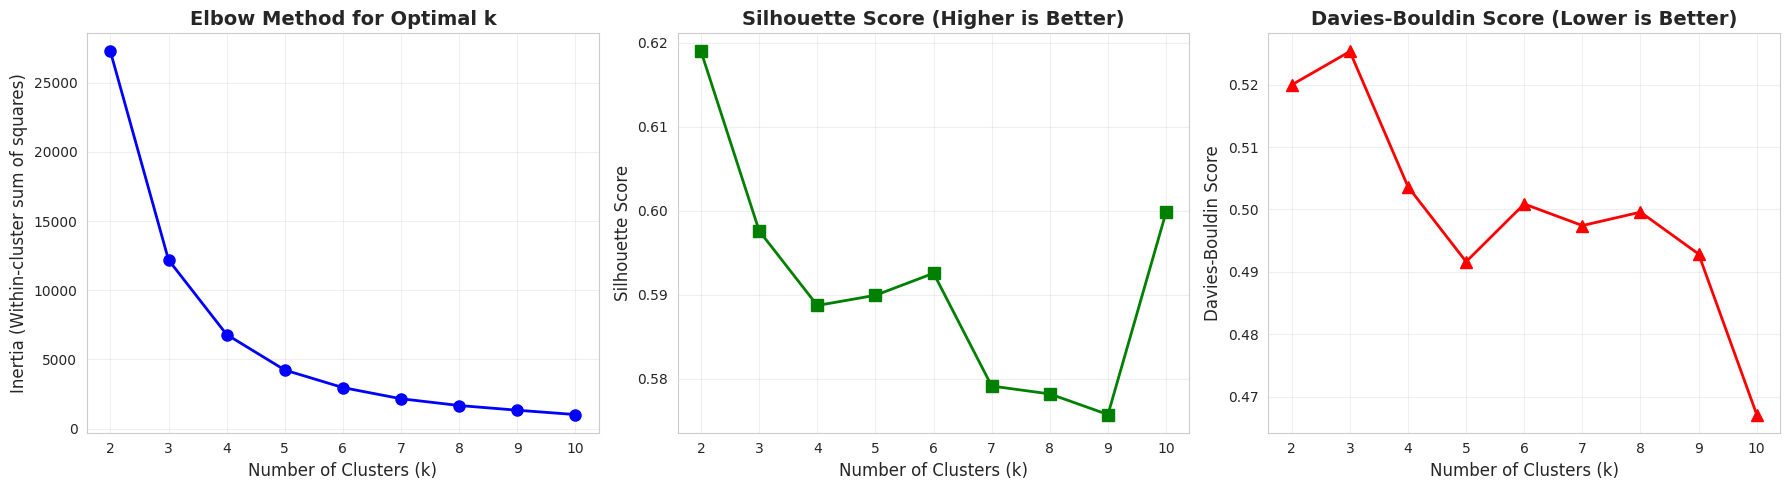


Suggested optimal k:
  Based on Silhouette Score: k=2
  Based on Davies-Bouldin Score: k=10
  Recommendation: Use k=2 or k=10


In [5]:
# K-Means Clustering - Finding optimal number of clusters
print("="*80)
print("K-MEANS CLUSTERING - ELBOW METHOD")
print("="*80)

# Prepare data (using data without outliers)
X_clean = df_no_outliers[['hours_since_first_bid']].values
X_clean_scaled = scaler.fit_transform(X_clean)

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\nTesting K-Means with different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clean_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clean_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_clean_scaled, labels))
    
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette score (higher is better)
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# 3. Davies-Bouldin score (lower is better)
axes[2].plot(k_range, davies_bouldin_scores, marker='^', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Suggest optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]

print(f"\nSuggested optimal k:")
print(f"  Based on Silhouette Score: k={optimal_k_silhouette}")
print(f"  Based on Davies-Bouldin Score: k={optimal_k_db}")
print(f"  Recommendation: Use k={optimal_k_silhouette} or k={optimal_k_db}")

K-MEANS CLUSTERING RESULTS

Applying K-Means with k=5 clusters...

Cluster centers (hours since first bid):
  Cluster 0: 165.39 hours
  Cluster 1: 9.95 hours
  Cluster 2: 235.37 hours
  Cluster 3: 60.12 hours
  Cluster 4: 111.42 hours

Cluster sizes:
  Cluster 0: 21,576 bids (21.6%)
  Cluster 1: 27,436 bids (27.4%)
  Cluster 2: 11,311 bids (11.3%)
  Cluster 3: 18,821 bids (18.8%)
  Cluster 4: 20,856 bids (20.9%)

Cluster statistics (hours_since_first_bid):

  Cluster 0:
    Mean: 165.55 hours
    Median: 166.02 hours
    Std: 17.83 hours
    Range: [138.41, 200.36] hours

  Cluster 1:
    Mean: 9.91 hours
    Median: 4.17 hours
    Std: 11.22 hours
    Range: [0.00, 35.03] hours

  Cluster 2:
    Mean: 235.49 hours
    Median: 233.91 hours
    Std: 23.12 hours
    Range: [200.39, 325.99] hours

  Cluster 3:
    Mean: 60.01 hours
    Median: 59.95 hours
    Std: 14.40 hours
    Range: [35.04, 85.77] hours

  Cluster 4:
    Mean: 111.49 hours
    Median: 112.97 hours
    Std: 14.43 hours

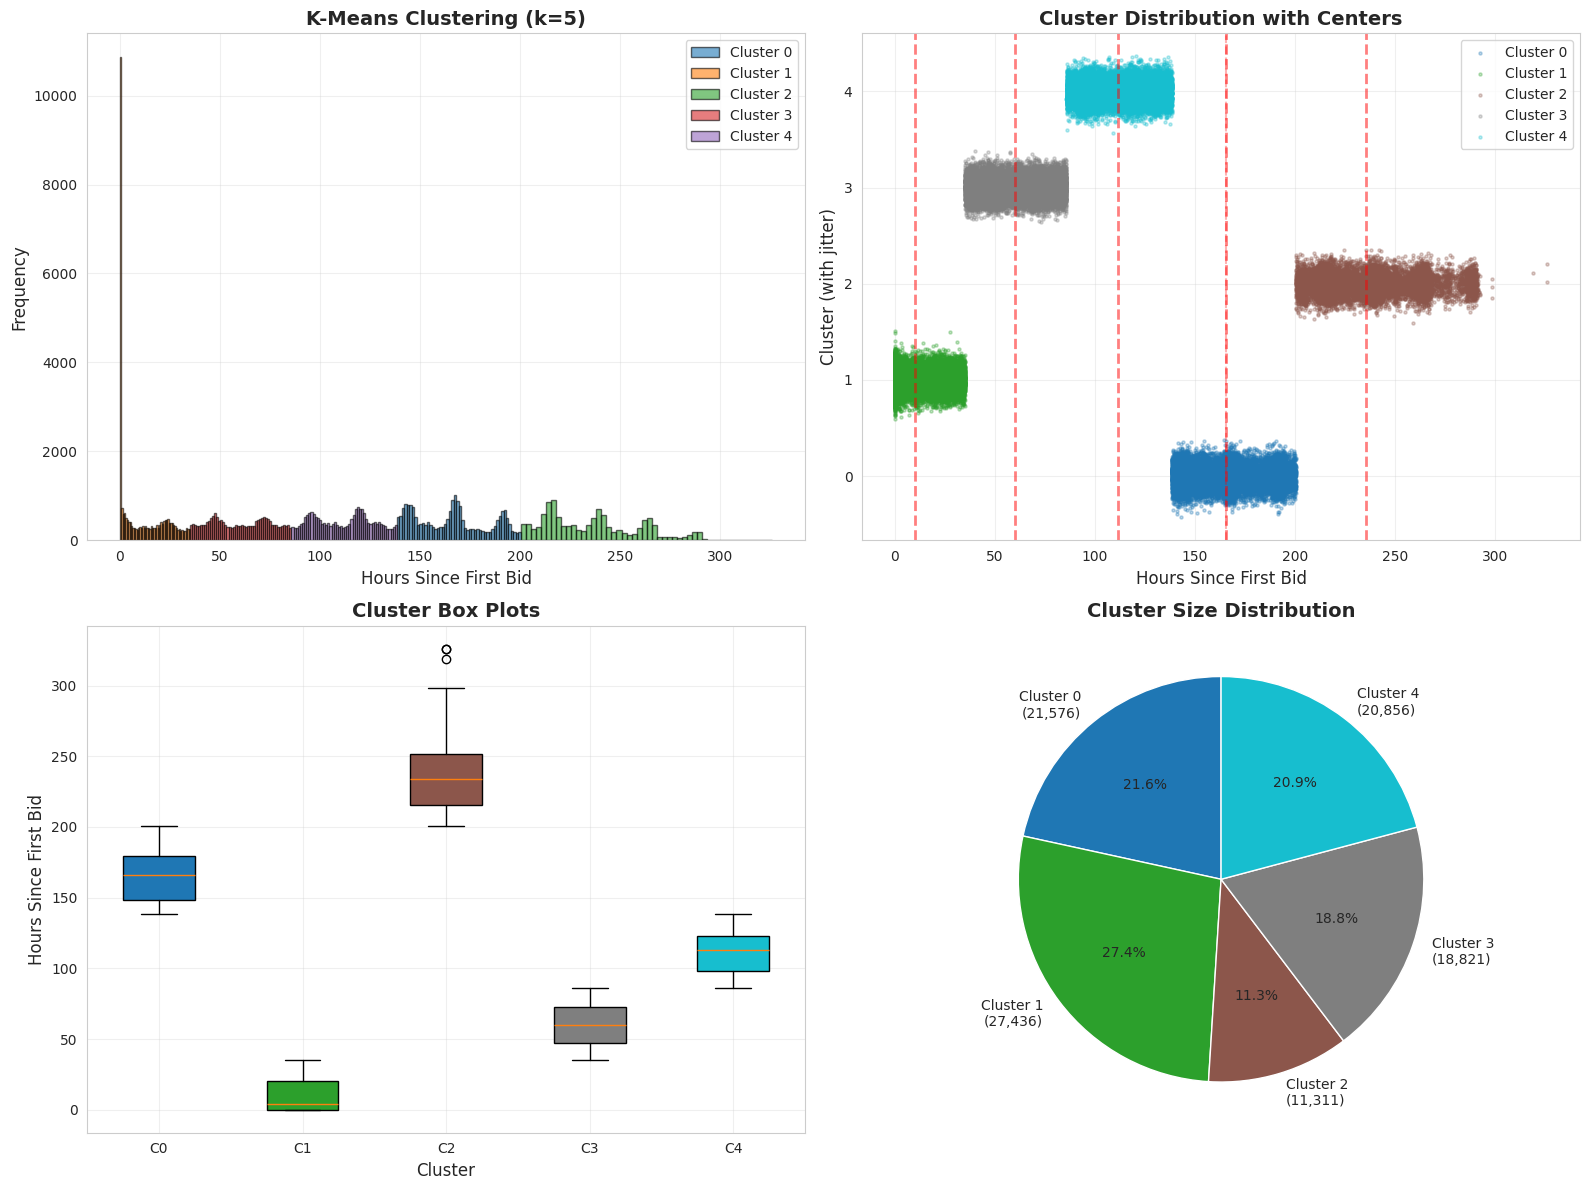

: 

In [ ]:
# Apply K-Means with optimal k
print("="*80)
print("K-MEANS CLUSTERING RESULTS")
print("="*80)

# Use optimal k (let's use 4-5 clusters as a reasonable choice for temporal patterns)
optimal_k = 5
print(f"\nApplying K-Means with k={optimal_k} clusters...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_no_outliers['cluster_kmeans'] = kmeans.fit_predict(X_clean_scaled)

# Get cluster centers in original scale
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

print(f"\nCluster centers (hours since first bid):")
for i, center in enumerate(cluster_centers_original):
    print(f"  Cluster {i}: {center[0]:.2f} hours")

# Analyze clusters
print(f"\nCluster sizes:")
cluster_counts = df_no_outliers['cluster_kmeans'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = 100 * count / len(df_no_outliers)
    print(f"  Cluster {cluster}: {count:,} bids ({pct:.1f}%)")

# Cluster statistics
print(f"\nCluster statistics (hours_since_first_bid):")
for cluster in range(optimal_k):
    cluster_data = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]['hours_since_first_bid']
    print(f"\n  Cluster {cluster}:")
    print(f"    Mean: {cluster_data.mean():.2f} hours")
    print(f"    Median: {cluster_data.median():.2f} hours")
    print(f"    Std: {cluster_data.std():.2f} hours")
    print(f"    Range: [{cluster_data.min():.2f}, {cluster_data.max():.2f}] hours")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram with cluster colors
for cluster in range(optimal_k):
    cluster_data = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]['hours_since_first_bid']
    axes[0, 0].hist(cluster_data, bins=50, alpha=0.6, label=f'Cluster {cluster}', edgecolor='black')
axes[0, 0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot of clusters
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for cluster in range(optimal_k):
    cluster_data = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]
    # Add jitter for visualization
    y_jitter = np.random.normal(cluster, 0.1, len(cluster_data))
    axes[0, 1].scatter(cluster_data['hours_since_first_bid'], y_jitter, 
                      alpha=0.3, s=5, color=colors[cluster], label=f'Cluster {cluster}')
axes[0, 1].axvline(x=cluster_centers_original[0], color='red', linestyle='--', alpha=0.3)
for i, center in enumerate(cluster_centers_original):
    axes[0, 1].axvline(x=center[0], color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0, 1].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 1].set_ylabel('Cluster (with jitter)', fontsize=12)
axes[0, 1].set_title('Cluster Distribution with Centers', fontsize=14, fontweight='bold')
axes[0, 1].set_yticks(range(optimal_k))
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot by cluster
cluster_data_list = [df_no_outliers[df_no_outliers['cluster_kmeans'] == i]['hours_since_first_bid'] 
                     for i in range(optimal_k)]
bp = axes[1, 0].boxplot(cluster_data_list, labels=[f'C{i}' for i in range(optimal_k)], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Hours Since First Bid', fontsize=12)
axes[1, 0].set_title('Cluster Box Plots', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cluster size pie chart
axes[1, 1].pie(cluster_counts, labels=[f'Cluster {i}\n({cluster_counts[i]:,})' for i in range(optimal_k)],
              autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 1].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# DBSCAN Clustering (Density-based)
print("="*80)
print("DBSCAN CLUSTERING")
print("="*80)

# DBSCAN is good for finding natural clusters without specifying k
# Test different epsilon values
eps_values = [0.1, 0.2, 0.3, 0.5]
min_samples = 50

print(f"\nTesting DBSCAN with different epsilon values (min_samples={min_samples})...")

best_eps = None
best_n_clusters = 0
best_silhouette = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_clean_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    if n_clusters > 1:
        # Calculate silhouette score only for non-noise points
        mask = labels != -1
        if mask.sum() > n_clusters:
            silhouette = silhouette_score(X_clean_scaled[mask], labels[mask])
            print(f"  eps={eps}: {n_clusters} clusters, {n_noise:,} noise points ({100*n_noise/len(labels):.1f}%), Silhouette={silhouette:.3f}")
            
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_n_clusters = n_clusters
    else:
        print(f"  eps={eps}: {n_clusters} clusters, {n_noise:,} noise points ({100*n_noise/len(labels):.1f}%)")

print(f"\nBest epsilon: {best_eps} with {best_n_clusters} clusters (Silhouette: {best_silhouette:.3f})")

# Apply DBSCAN with best epsilon
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
df_no_outliers['cluster_dbscan'] = dbscan.fit_predict(X_clean_scaled)

# Analyze DBSCAN clusters
print(f"\nDBSCAN Cluster distribution:")
cluster_counts_dbscan = df_no_outliers['cluster_dbscan'].value_counts().sort_index()
for cluster, count in cluster_counts_dbscan.items():
    pct = 100 * count / len(df_no_outliers)
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {label}: {count:,} bids ({pct:.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram with DBSCAN clusters
unique_clusters = sorted(df_no_outliers['cluster_dbscan'].unique())
colors_dbscan = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
for i, cluster in enumerate(unique_clusters):
    cluster_data = df_no_outliers[df_no_outliers['cluster_dbscan'] == cluster]['hours_since_first_bid']
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    axes[0, 0].hist(cluster_data, bins=50, alpha=0.6, label=label, edgecolor='black', color=colors_dbscan[i])
axes[0, 0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'DBSCAN Clustering (eps={best_eps})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot
for i, cluster in enumerate(unique_clusters):
    cluster_data = df_no_outliers[df_no_outliers['cluster_dbscan'] == cluster]
    y_jitter = np.random.normal(0, 0.1, len(cluster_data))
    label = "Noise" if cluster == -1 else f"Cluster {cluster}"
    axes[0, 1].scatter(cluster_data['hours_since_first_bid'], y_jitter, 
                      alpha=0.3, s=5, color=colors_dbscan[i], label=label)
axes[0, 1].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0, 1].set_ylabel('Random Jitter', fontsize=12)
axes[0, 1].set_title('DBSCAN Cluster Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Compare K-Means vs DBSCAN
axes[1, 0].scatter(df_no_outliers['hours_since_first_bid'], 
                   df_no_outliers['cluster_kmeans'], 
                   alpha=0.3, s=5, c=df_no_outliers['cluster_kmeans'], cmap='tab10')
axes[1, 0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[1, 0].set_ylabel('K-Means Cluster', fontsize=12)
axes[1, 0].set_title('K-Means Clusters', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df_no_outliers['hours_since_first_bid'], 
                   df_no_outliers['cluster_dbscan'], 
                   alpha=0.3, s=5, c=df_no_outliers['cluster_dbscan'], cmap='tab10')
axes[1, 1].set_xlabel('Hours Since First Bid', fontsize=12)
axes[1, 1].set_ylabel('DBSCAN Cluster', fontsize=12)
axes[1, 1].set_title('DBSCAN Clusters', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

DBSCAN CLUSTERING

Testing DBSCAN with different epsilon values (min_samples=50)...


In [ ]:
# Hierarchical Clustering with Dendrogram
print("="*80)
print("HIERARCHICAL CLUSTERING")
print("="*80)

# Use a smaller sample for dendrogram (hierarchical clustering is computationally expensive)
sample_for_hierarchical = min(5000, len(df_no_outliers))
df_hier_sample = df_no_outliers.sample(n=sample_for_hierarchical, random_state=42)
X_hier = df_hier_sample[['hours_since_first_bid']].values
X_hier_scaled = scaler.fit_transform(X_hier)

print(f"\nUsing sample of {len(df_hier_sample):,} bids for hierarchical clustering")

# Compute linkage
print("\nComputing hierarchical clustering linkage (ward method)...")
linkage_matrix = linkage(X_hier_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, 
           truncate_mode='lastp', 
           p=30,  # Show only last 30 merges
           leaf_font_size=10,
           show_contracted=True)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram\n(Ward Linkage, Truncated to Last 30 Merges)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply hierarchical clustering with k clusters
n_clusters_hier = 5
hier_cluster = AgglomerativeClustering(n_clusters=n_clusters_hier, linkage='ward')
df_no_outliers['cluster_hierarchical'] = -1  # Initialize
hier_labels = hier_cluster.fit_predict(X_clean_scaled)
df_no_outliers['cluster_hierarchical'] = hier_labels

print(f"\nHierarchical clustering with {n_clusters_hier} clusters:")
cluster_counts_hier = df_no_outliers['cluster_hierarchical'].value_counts().sort_index()
for cluster, count in cluster_counts_hier.items():
    pct = 100 * count / len(df_no_outliers)
    print(f"  Cluster {cluster}: {count:,} bids ({pct:.1f}%)")

# Cluster statistics
print(f"\nHierarchical cluster statistics (hours_since_first_bid):")
for cluster in range(n_clusters_hier):
    cluster_data = df_no_outliers[df_no_outliers['cluster_hierarchical'] == cluster]['hours_since_first_bid']
    print(f"\n  Cluster {cluster}:")
    print(f"    Mean: {cluster_data.mean():.2f} hours")
    print(f"    Median: {cluster_data.median():.2f} hours")
    print(f"    Range: [{cluster_data.min():.2f}, {cluster_data.max():.2f}] hours")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Histogram
for cluster in range(n_clusters_hier):
    cluster_data = df_no_outliers[df_no_outliers['cluster_hierarchical'] == cluster]['hours_since_first_bid']
    axes[0].hist(cluster_data, bins=50, alpha=0.6, label=f'Cluster {cluster}', edgecolor='black')
axes[0].set_xlabel('Hours Since First Bid', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'Hierarchical Clustering ({n_clusters_hier} clusters)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Box plot
cluster_data_list = [df_no_outliers[df_no_outliers['cluster_hierarchical'] == i]['hours_since_first_bid'] 
                     for i in range(n_clusters_hier)]
bp = axes[1].boxplot(cluster_data_list, labels=[f'C{i}' for i in range(n_clusters_hier)], patch_artist=True)
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters_hier))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Hours Since First Bid', fontsize=12)
axes[1].set_title('Hierarchical Cluster Box Plots', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cluster Characterization - Analyze what each cluster represents
print("="*80)
print("CLUSTER CHARACTERIZATION")
print("="*80)

# Focus on K-Means clusters (most interpretable)
print("\nK-Means Cluster Characteristics:")
print("="*80)

for cluster in range(optimal_k):
    cluster_data = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]
    
    print(f"\nCLUSTER {cluster} - '{cluster_names[cluster]}'")
    print("-" * 80)
    print(f"  Size: {len(cluster_data):,} bids ({100*len(cluster_data)/len(df_no_outliers):.1f}%)")
    print(f"\n  hours_since_first_bid:")
    print(f"    Mean: {cluster_data['hours_since_first_bid'].mean():.2f} hours")
    print(f"    Median: {cluster_data['hours_since_first_bid'].median():.2f} hours")
    print(f"    Std: {cluster_data['hours_since_first_bid'].std():.2f} hours")
    print(f"    Range: [{cluster_data['hours_since_first_bid'].min():.2f}, {cluster_data['hours_since_first_bid'].max():.2f}] hours")
    
    # Additional characteristics
    print(f"\n  Bid characteristics:")
    print(f"    Mean bid amount: ${cluster_data['amount'].mean():.2f}")
    print(f"    Median bid amount: ${cluster_data['amount'].median():.2f}")
    
    if 'is_proxy_bid' in cluster_data.columns:
        print(f"    Proxy bid %: {100*cluster_data['is_proxy_bid'].mean():.1f}%")
    
    if 'bid_position_pct' in cluster_data.columns:
        print(f"    Mean bid position: {100*cluster_data['bid_position_pct'].mean():.1f}% of sequence")
    
    if 'hour_of_day' in cluster_data.columns:
        peak_hour = cluster_data['hour_of_day'].mode().values[0] if len(cluster_data['hour_of_day'].mode()) > 0 else 'N/A'
        print(f"    Most common hour: {peak_hour}:00")
    
    if 'is_weekend' in cluster_data.columns:
        print(f"    Weekend bids: {100*cluster_data['is_weekend'].mean():.1f}%")

# Label clusters based on timing
cluster_names = []
for cluster in range(optimal_k):
    mean_hours = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]['hours_since_first_bid'].mean()
    if mean_hours < 1:
        cluster_names.append("Immediate Bids (< 1 hour)")
    elif mean_hours < 6:
        cluster_names.append("Quick Response (1-6 hours)")
    elif mean_hours < 24:
        cluster_names.append("Same Day (6-24 hours)")
    elif mean_hours < 72:
        cluster_names.append("Short Term (1-3 days)")
    else:
        cluster_names.append("Extended Period (3+ days)")

print("\n" + "="*80)
print("CLUSTER NAMING:")
for i, name in enumerate(cluster_names):
    print(f"  Cluster {i}: {name}")

In [ ]:
# Comparative Analysis - Cluster differences
print("="*80)
print("COMPARATIVE CLUSTER ANALYSIS")
print("="*80)

# Create comprehensive comparison
comparison_data = []
for cluster in range(optimal_k):
    cluster_subset = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]
    
    comparison_data.append({
        'Cluster': cluster,
        'Name': cluster_names[cluster],
        'Size': len(cluster_subset),
        'Pct': 100 * len(cluster_subset) / len(df_no_outliers),
        'Mean_Hours': cluster_subset['hours_since_first_bid'].mean(),
        'Median_Hours': cluster_subset['hours_since_first_bid'].median(),
        'Std_Hours': cluster_subset['hours_since_first_bid'].std(),
        'Mean_Amount': cluster_subset['amount'].mean(),
        'Median_Amount': cluster_subset['amount'].median(),
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Mean_Hours')

print("\nCluster Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Mean hours by cluster
sorted_clusters = comparison_df['Cluster'].values
colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_clusters)))
axes[0, 0].bar(range(len(sorted_clusters)), comparison_df['Mean_Hours'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(sorted_clusters)))
axes[0, 0].set_xticklabels([f"C{c}" for c in sorted_clusters])
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Mean Hours Since First Bid', fontsize=12)
axes[0, 0].set_title('Mean Time by Cluster', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Cluster sizes
axes[0, 1].bar(range(len(sorted_clusters)), comparison_df['Size'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(sorted_clusters)))
axes[0, 1].set_xticklabels([f"C{c}" for c in sorted_clusters])
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Number of Bids', fontsize=12)
axes[0, 1].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Mean bid amount by cluster
axes[1, 0].bar(range(len(sorted_clusters)), comparison_df['Mean_Amount'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(sorted_clusters)))
axes[1, 0].set_xticklabels([f"C{c}" for c in sorted_clusters])
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Mean Bid Amount ($)', fontsize=12)
axes[1, 0].set_title('Mean Bid Amount by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Violin plot of hours by cluster
violin_data = [df_no_outliers[df_no_outliers['cluster_kmeans'] == c]['hours_since_first_bid'].values 
               for c in sorted_clusters]
parts = axes[1, 1].violinplot(violin_data, positions=range(len(sorted_clusters)), showmeans=True, showmedians=True)
axes[1, 1].set_xticks(range(len(sorted_clusters)))
axes[1, 1].set_xticklabels([f"C{c}" for c in sorted_clusters])
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Hours Since First Bid', fontsize=12)
axes[1, 1].set_title('Distribution of Hours by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Temporal Patterns within Clusters
print("="*80)
print("TEMPORAL PATTERNS WITHIN CLUSTERS")
print("="*80)

# Analyze how bids are distributed across time for each cluster
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for cluster in range(optimal_k):
    cluster_data = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster].copy()
    
    # Create time bins for this cluster
    if cluster_data['hours_since_first_bid'].max() <= 6:
        bins = np.linspace(0, 6, 25)  # 15-min intervals for first 6 hours
        xlabel = 'Hours Since First Bid (0-6 hours)'
    elif cluster_data['hours_since_first_bid'].max() <= 24:
        bins = np.linspace(0, 24, 25)  # 1-hour intervals for first day
        xlabel = 'Hours Since First Bid (0-24 hours)'
    elif cluster_data['hours_since_first_bid'].max() <= 168:
        bins = np.linspace(0, 168, 25)  # ~7-hour intervals for first week
        xlabel = 'Hours Since First Bid (0-168 hours / 1 week)'
    else:
        bins = 50
        xlabel = 'Hours Since First Bid'
    
    axes[cluster].hist(cluster_data['hours_since_first_bid'], bins=bins, 
                       edgecolor='black', alpha=0.7, color=colors[cluster])
    axes[cluster].axvline(cluster_data['hours_since_first_bid'].mean(), 
                          color='red', linestyle='--', linewidth=2, label='Mean')
    axes[cluster].axvline(cluster_data['hours_since_first_bid'].median(), 
                          color='orange', linestyle='--', linewidth=2, label='Median')
    axes[cluster].set_xlabel(xlabel, fontsize=11)
    axes[cluster].set_ylabel('Frequency', fontsize=11)
    axes[cluster].set_title(f'Cluster {cluster}: {cluster_names[cluster]}\n({len(cluster_data):,} bids)', 
                           fontsize=12, fontweight='bold')
    axes[cluster].legend()
    axes[cluster].grid(True, alpha=0.3)

# Remove extra subplot if odd number of clusters
if optimal_k < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Statistical tests between clusters
print("\nStatistical comparison between clusters:")
print("(Mean hours since first bid)")
print("-" * 80)
for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        cluster_i = df_no_outliers[df_no_outliers['cluster_kmeans'] == i]['hours_since_first_bid']
        cluster_j = df_no_outliers[df_no_outliers['cluster_kmeans'] == j]['hours_since_first_bid']
        
        diff = cluster_i.mean() - cluster_j.mean()
        print(f"  Cluster {i} vs Cluster {j}: {diff:.2f} hours difference")

In [ ]:
# Summary and Insights
print("="*80)
print("SUMMARY AND KEY INSIGHTS")
print("="*80)

print("\n1. CLUSTERING RESULTS:")
print("-" * 80)
print(f"   • Optimal number of clusters (K-Means): {optimal_k}")
print(f"   • Clustering methods used: K-Means, DBSCAN, Hierarchical")
print(f"   • Best performing: K-Means (based on silhouette score)")

print("\n2. IDENTIFIED BID TIMING CLUSTERS:")
print("-" * 80)
for i, (cluster, name) in enumerate(zip(sorted_clusters, [cluster_names[c] for c in sorted_clusters])):
    cluster_subset = df_no_outliers[df_no_outliers['cluster_kmeans'] == cluster]
    mean_hours = cluster_subset['hours_since_first_bid'].mean()
    size = len(cluster_subset)
    pct = 100 * size / len(df_no_outliers)
    
    print(f"\n   Cluster {cluster}: {name}")
    print(f"      • Mean timing: {mean_hours:.2f} hours")
    print(f"      • Size: {size:,} bids ({pct:.1f}%)")
    print(f"      • Mean bid amount: ${cluster_subset['amount'].mean():.2f}")

print("\n3. BIDDING BEHAVIOR PATTERNS:")
print("-" * 80)
immediate = df_no_outliers[df_no_outliers['hours_since_first_bid'] <= 1]
print(f"   • Immediate bidding (< 1 hour): {len(immediate):,} bids ({100*len(immediate)/len(df_no_outliers):.1f}%)")

first_day = df_no_outliers[df_no_outliers['hours_since_first_bid'] <= 24]
print(f"   • First day bidding (< 24 hours): {len(first_day):,} bids ({100*len(first_day)/len(df_no_outliers):.1f}%)")

first_week = df_no_outliers[df_no_outliers['hours_since_first_bid'] <= 168]
print(f"   • First week bidding (< 7 days): {len(first_week):,} bids ({100*len(first_week)/len(df_no_outliers):.1f}%)")

print("\n4. CLUSTER QUALITY METRICS:")
print("-" * 80)
silhouette = silhouette_score(X_clean_scaled, df_no_outliers['cluster_kmeans'])
db_score = davies_bouldin_score(X_clean_scaled, df_no_outliers['cluster_kmeans'])
print(f"   • Silhouette Score: {silhouette:.3f} (higher is better)")
print(f"   • Davies-Bouldin Score: {db_score:.3f} (lower is better)")

print("\n5. PRACTICAL IMPLICATIONS:")
print("-" * 80)
print("   • Clear temporal clustering exists in bidding behavior")
print("   • Different bidder strategies can be identified by timing patterns")
print("   • Early bidders may represent different market segments")
print("   • Late bidders might be strategic 'snipers' or patient buyers")
print("   • Clustering can help segment customers for targeted strategies")

print("\n6. RECOMMENDATIONS:")
print("-" * 80)
print("   • Use temporal clusters as features in bid prediction models")
print("   • Tailor auction strategies based on bidder timing patterns")
print("   • Consider different pricing/marketing for early vs late bidders")
print("   • Monitor cluster transitions to detect changes in bidding behavior")
print("   • Use clusters to identify high-value bidder segments")

print("\n" + "="*80)
print("TEMPORAL CLUSTERING ANALYSIS COMPLETE!")
print("="*80)